In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Optional


class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series sequences."""
    
    def __init__(self, data: np.ndarray, sequence_length: int, device):
        """
        Args:
            data: numpy array of shape (n_samples, n_features)
            sequence_length: length of each sequence
        """
        self.data = torch.from_numpy(data).float().to(device)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.sequence_length]
        # return torch.FloatTensor(sequence)
        return sequence


class LSTMAutoencoder(nn.Module):
    """LSTM Autoencoder for time series anomaly detection."""
    
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, dropout: float = 0.2):
        """
        Args:
            input_dim: number of features in input
            hidden_dim: number of hidden units in LSTM
            num_layers: number of LSTM layers
            dropout: dropout probability
        """
        super(LSTMAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Decoder
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        """
        Args:
            x: input tensor of shape (batch_size, sequence_length, input_dim)
        
        Returns:
            reconstructed sequence of same shape as input
        """
        batch_size, seq_len, _ = x.shape
        
        # Encode
        encoded, (hidden, cell) = self.encoder(x)
        
        # Use the last encoded state as input to decoder
        # Repeat it for each time step
        decoder_input = encoded[:, -1:, :].repeat(1, seq_len, 1)
        
        # Decode
        decoded, _ = self.decoder(decoder_input, (hidden, cell))
        
        # Output
        output = self.output_layer(decoded)
        
        return output


class AnomalyDetector:
    """Complete pipeline for LSTM-based anomaly detection."""
    
    def __init__(
        self,
        sequence_length: int = 50,
        hidden_dim: int = 64,
        num_layers: int = 2,
        dropout: float = 0.2,
        learning_rate: float = 0.001,
        batch_size: int = 32,
        epochs: int = 50,
        device: Optional[str] = None
    ):
        """
        Args:
            sequence_length: length of input sequences
            hidden_dim: LSTM hidden dimension
            num_layers: number of LSTM layers
            dropout: dropout probability
            learning_rate: learning rate for optimizer
            batch_size: batch size for training
            epochs: number of training epochs
            device: 'cuda' or 'cpu', auto-detected if None
        """
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        
        # Set device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.scaler = StandardScaler()
        self.model = None
        self.threshold = None
        
    def prepare_data(
        self,
        df: pd.DataFrame,
        test_size: float = 0.2,
        random_state: int = 42
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Prepare data by removing anomalies from training set and standardizing.
        
        Args:
            df: pandas DataFrame with features and 'is_anomaly' column
            test_size: proportion of data for testing
            random_state: random seed for reproducibility
            
        Returns:
            X_train, X_test, y_train, y_test (standardized features and labels)
        """
        # Separate features and labels
        X = df.drop('is_anomaly', axis=1).values
        y = df['is_anomaly'].values
        
        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split( # don't split up the time data
            X, y, test_size=test_size, random_state=random_state, shuffle=False
        )
        
        # Remove anomalous samples from training data
        normal_mask = y_train == 0
        X_train_normal = X_train[normal_mask]
        
        print(f"Original training samples: {len(X_train)}")
        print(f"Training samples after removing anomalies: {len(X_train_normal)}")
        print(f"Anomalies removed: {len(X_train) - len(X_train_normal)}")
        
        # Fit scaler on normal training data only
        self.scaler.fit(X_train_normal)
        
        # Transform all data
        X_train_scaled = self.scaler.transform(X_train_normal)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Update y_train to match the filtered X_train
        y_train_normal = y_train[normal_mask]
        
        return X_train_scaled, X_test_scaled, y_train_normal, y_test

    def train(
        self,
        X_train: np.ndarray,
        verbose: bool = True
    ):
        """
        Train the LSTM autoencoder.
        
        Args:
            X_train: training data of shape (n_samples, n_features)
            verbose: whether to print training progress
        """
        from tqdm import tqdm
        # Create dataset and dataloader
        train_dataset = TimeSeriesDataset(X_train, self.sequence_length, self.device)
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True
        )

        print("initialized dataset")
        
        # Initialize model
        input_dim = X_train.shape[1]
        self.model = LSTMAutoencoder(
            input_dim=input_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.dropout
        ).to(self.device)

        print("initialized model")
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Training loop
        self.model.train()
        train_losses = []
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            for batch in tqdm(train_loader):
                batch = batch.to(self.device)
                
                # Forward pass
                reconstructed = self.model(batch)
                loss = criterion(reconstructed, batch)
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_loss)
            
            if verbose: # and (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.6f}')
        
        return train_losses
    
    # def calculate_reconstruction_error(self, X: np.ndarray) -> np.ndarray:
    #     """
    #     Calculate reconstruction error for each sequence.
        
    #     Args:
    #         X: data of shape (n_samples, n_features)
            
    #     Returns:
    #         reconstruction errors for each sequence
    #     """

    #     self.model.eval()
    #     dataset = TimeSeriesDataset(X, self.sequence_length, self.device)
    #     loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
    #     errors = []
        
    #     with torch.no_grad():
    #         for batch in loader:
    #             batch = batch.to(self.device)
    #             reconstructed = self.model(batch)
                
    #             # Calculate MSE for each sequence
    #             mse = torch.mean((batch - reconstructed) ** 2, dim=(1, 2))
    #             errors.extend(mse.cpu().numpy())
        
    #     return np.array(errors)
    def new_calculate_reconstruction_error(self, X: np.ndarray) -> np.ndarray:
        """
        Calculate reconstruction error for each sequence.
        
        Args:
            X: data of shape (n_samples, n_features)
            
        Returns:
            reconstruction errors for each sequence
        """

        self.model.eval()
        dataset = TimeSeriesDataset(X, self.sequence_length, self.device)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        errors = []
        
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                reconstructed = self.model(batch)
                
                # Calculate MSE for each sequence
                # mse = torch.mean((batch - reconstructed) ** 2, dim=(1, 2))
                # errors.extend(mse.cpu().numpy())
                batch_shape = batch.shape
                reconstructed_shape = reconstructed.shape
                # print("shapes:", batch_shape, reconstructed_shape)
                batch_flat = batch.view(batch_shape[0], batch_shape[1]*batch_shape[2])
                reconstructed_flat = reconstructed.view(reconstructed_shape[0], reconstructed_shape[1]*reconstructed_shape[2])
                sim = F.cosine_similarity(batch_flat, reconstructed_flat, dim=-1)
                error = 1 - sim
                errors.extend(error.cpu().numpy())
                
        
        return np.array(errors)
    
    def set_threshold(self, X_train: np.ndarray, percentile: float = 95):
        """
        Set anomaly threshold based on training data reconstruction error.
        
        Args:
            X_train: training data
            percentile: percentile of training errors to use as threshold
        """
        train_errors = self.calculate_reconstruction_error(X_train)
        self.threshold = np.percentile(train_errors, percentile)
        print(f"Anomaly threshold set to: {self.threshold:.6f}")
        return self.threshold
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict anomalies based on reconstruction error.
        
        Args:
            X: data to predict on
            
        Returns:
            binary predictions (1 for anomaly, 0 for normal)
        """
        if self.threshold is None:
            raise ValueError("Threshold not set. Call set_threshold() first.")
        
        errors = self.calculate_reconstruction_error(X)
        predictions = (errors > self.threshold).astype(int)
        
        # Pad predictions to match original data length
        padding = np.zeros(self.sequence_length - 1)
        predictions = np.concatenate([padding, predictions])
        
        return predictions
    
    def evaluate(
        self,
        X_test: np.ndarray,
        y_test: np.ndarray,
        plot: bool = True
    ) -> dict:
        """
        Evaluate model performance on test data.
        
        Args:
            X_test: test features
            y_test: test labels
            plot: whether to plot results
            
        Returns:
            dictionary with evaluation metrics
        """
        from sklearn.metrics import (
            precision_score, recall_score, f1_score,
            confusion_matrix, classification_report
        )
        
        # Get predictions
        predictions = self.predict(X_test)
        
        # Align predictions with labels (account for sequence length)
        y_test_aligned = y_test[self.sequence_length - 1:]
        predictions_aligned = predictions[self.sequence_length - 1:]
        
        # Calculate metrics
        precision = precision_score(y_test_aligned, predictions_aligned, zero_division=0)
        recall = recall_score(y_test_aligned, predictions_aligned, zero_division=0)
        f1 = f1_score(y_test_aligned, predictions_aligned, zero_division=0)
        cm = confusion_matrix(y_test_aligned, predictions_aligned)
        
        results = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }
        
        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(y_test_aligned, predictions_aligned))
        
        if plot:
            self._plot_results(X_test, y_test, predictions)
        
        return results
    
    def _plot_results(self, X_test: np.ndarray, y_test: np.ndarray, predictions: np.ndarray):
        """Plot reconstruction errors and anomaly predictions."""
        errors = self.calculate_reconstruction_error(X_test)
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 8))
        
        # Plot reconstruction error
        x_axis = np.arange(len(errors)) + self.sequence_length - 1
        axes[0].plot(x_axis, errors, label='Reconstruction Error', alpha=0.7)
        axes[0].axhline(y=self.threshold, color='r', linestyle='--', label='Threshold')
        axes[0].set_xlabel('Time Step')
        axes[0].set_ylabel('Reconstruction Error')
        axes[0].set_title('Reconstruction Error Over Time')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot predictions vs ground truth
        axes[1].plot(y_test, label='Ground Truth', alpha=0.7, linewidth=2)
        axes[1].plot(predictions, label='Predictions', alpha=0.7, linewidth=2)
        axes[1].set_xlabel('Time Step')
        axes[1].set_ylabel('Anomaly Label')
        axes[1].set_title('Anomaly Detection: Predictions vs Ground Truth')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        # plt.savefig('/mnt/user-data/outputs/anomaly_detection_results.png', dpi=150, bbox_inches='tight')
        # plt.close()
        plt.show()
        
        # print("\nPlot saved to: anomaly_detection_results.png")


# Example usage
# if __name__ == "__main__":
#     # Generate synthetic data for demonstration
#     np.random.seed(42)
#     n_samples = 2000
#     n_features = 5
    
#     # Create normal data
#     t = np.linspace(0, 100, n_samples)
#     data = np.column_stack([
#         np.sin(t * 0.1 + i) + np.random.normal(0, 0.1, n_samples)
#         for i in range(n_features)
#     ])
    
#     # Add anomalies
#     anomaly_indices = np.random.choice(n_samples, size=100, replace=False)
#     is_anomaly = np.zeros(n_samples)
#     is_anomaly[anomaly_indices] = 1
    
#     for idx in anomaly_indices:
#         data[idx] = data[idx] + np.random.normal(3, 1, n_features)
    
#     # Create DataFrame
#     df = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(n_features)])
#     df['is_anomaly'] = is_anomaly
    
    # print("="*50)
    # print("LSTM AUTOENCODER ANOMALY DETECTION")
    # print("="*50)
    # print(f"\nDataset shape: {df.shape}")
    # print(f"Number of anomalies: {df['is_anomaly'].sum()}")
    # print(f"Anomaly ratio: {df['is_anomaly'].mean():.2%}")
    
    # # Initialize detector
    # detector = AnomalyDetector(
    #     sequence_length=50,
    #     hidden_dim=64,
    #     num_layers=2,
    #     dropout=0.2,
    #     learning_rate=0.001,
    #     batch_size=32,
    #     epochs=50
    # )
    
    # # Prepare data
    # print("\n" + "="*50)
    # print("DATA PREPARATION")
    # print("="*50)
    # X_train, X_test, y_train, y_test = detector.prepare_data(df, test_size=0.2)
    
    # # Train model
    # print("\n" + "="*50)
    # print("TRAINING")
    # print("="*50)
    # train_losses = detector.train(X_train, verbose=True)
    
    # # Set threshold
    # print("\n" + "="*50)
    # print("THRESHOLD CALCULATION")
    # print("="*50)
    # detector.set_threshold(X_train, percentile=95)
    
    # # Evaluate
    # results = detector.evaluate(X_test, y_test, plot=True)

In [11]:
parquet_train = "/home/cbelshe/CMPE-258/final_project/train.parquet"
train_df = pd.read_parquet(parquet_train)

In [16]:
print("="*50)
print("LSTM AUTOENCODER ANOMALY DETECTION")
print("="*50)
print(f"\nDataset shape: {train_df.shape}")
print(f"Number of anomalies: {train_df['is_anomaly'].sum()}")
print(f"Anomaly ratio: {train_df['is_anomaly'].mean():.2%}")

# Initialize detector
detector = AnomalyDetector(
    sequence_length=50,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
    learning_rate=0.001,
    batch_size=256,
    epochs=50
)

# Prepare data
print("\n" + "="*50)
print("DATA PREPARATION")
print("="*50)
X_train, X_test, y_train, y_test = detector.prepare_data(train_df, test_size=0.2)

LSTM AUTOENCODER ANOMALY DETECTION

Dataset shape: (14728321, 89)
Number of anomalies: 1544104
Anomaly ratio: 10.48%

DATA PREPARATION
Original training samples: 11782656
Training samples after removing anomalies: 10548727
Anomalies removed: 1233929


In [ ]:
# Train model
print("\n" + "="*50)
print("TRAINING")
print("="*50)
train_losses = detector.train(X_train, verbose=True)


TRAINING
initialized dataset
initialized model


100%|██████████| 41205/41205 [05:12<00:00, 131.80it/s]


Epoch [1/50], Loss: 0.330590


100%|██████████| 41205/41205 [05:09<00:00, 133.00it/s]


Epoch [2/50], Loss: 0.306851


100%|██████████| 41205/41205 [05:41<00:00, 120.50it/s]


Epoch [3/50], Loss: 0.297842


100%|██████████| 41205/41205 [05:27<00:00, 125.92it/s]


Epoch [4/50], Loss: 0.293872


100%|██████████| 41205/41205 [05:55<00:00, 115.77it/s]


Epoch [5/50], Loss: 0.298606


100%|██████████| 41205/41205 [06:00<00:00, 114.27it/s]


Epoch [6/50], Loss: 0.303035


100%|██████████| 41205/41205 [05:14<00:00, 130.91it/s]


Epoch [7/50], Loss: 0.305663


100%|██████████| 41205/41205 [04:48<00:00, 142.83it/s]


Epoch [8/50], Loss: 0.300201


100%|██████████| 41205/41205 [04:56<00:00, 139.06it/s]


Epoch [9/50], Loss: 0.302836


100%|██████████| 41205/41205 [04:48<00:00, 142.66it/s]


Epoch [10/50], Loss: 0.309352


100%|██████████| 41205/41205 [05:33<00:00, 123.40it/s]


Epoch [11/50], Loss: 0.303753


100%|██████████| 41205/41205 [05:48<00:00, 118.27it/s]


Epoch [13/50], Loss: 0.292002


100%|██████████| 41205/41205 [05:13<00:00, 131.51it/s]


Epoch [14/50], Loss: 0.292929


100%|██████████| 41205/41205 [06:19<00:00, 108.49it/s]


Epoch [15/50], Loss: 0.291324


100%|██████████| 41205/41205 [05:41<00:00, 120.56it/s]


Epoch [16/50], Loss: 0.290554


100%|██████████| 41205/41205 [05:32<00:00, 123.84it/s]


Epoch [17/50], Loss: 0.288957


100%|██████████| 41205/41205 [05:19<00:00, 129.09it/s]


Epoch [18/50], Loss: 0.300902


100%|██████████| 41205/41205 [05:23<00:00, 127.37it/s]


Epoch [19/50], Loss: 0.288544


100%|██████████| 41205/41205 [04:58<00:00, 138.26it/s]


Epoch [20/50], Loss: 0.288108


100%|██████████| 41205/41205 [05:00<00:00, 137.14it/s]


Epoch [21/50], Loss: 0.298034


100%|██████████| 41205/41205 [05:03<00:00, 135.80it/s]


Epoch [22/50], Loss: 0.350722


100%|██████████| 41205/41205 [04:56<00:00, 138.99it/s]


Epoch [23/50], Loss: 0.309371


100%|██████████| 41205/41205 [04:47<00:00, 143.25it/s]


Epoch [24/50], Loss: 0.281448


100%|██████████| 41205/41205 [05:50<00:00, 117.41it/s]


Epoch [25/50], Loss: 0.278693


100%|██████████| 41205/41205 [05:08<00:00, 133.52it/s]


Epoch [26/50], Loss: 0.256125


100%|██████████| 41205/41205 [05:11<00:00, 132.31it/s]


Epoch [27/50], Loss: 0.247080


100%|██████████| 41205/41205 [04:50<00:00, 141.76it/s]


Epoch [28/50], Loss: 0.248222


100%|██████████| 41205/41205 [04:48<00:00, 142.74it/s]


Epoch [29/50], Loss: 0.245078


100%|██████████| 41205/41205 [05:14<00:00, 131.03it/s]


Epoch [30/50], Loss: 0.245353


100%|██████████| 41205/41205 [05:13<00:00, 131.63it/s]


Epoch [31/50], Loss: 0.241598


100%|██████████| 41205/41205 [05:34<00:00, 123.16it/s]


Epoch [32/50], Loss: 0.239012


100%|██████████| 41205/41205 [05:27<00:00, 125.86it/s]


Epoch [33/50], Loss: 0.238717


100%|██████████| 41205/41205 [05:45<00:00, 119.39it/s]


Epoch [34/50], Loss: 0.266896


 11%|█         | 4573/41205 [00:40<04:15, 143.50it/s]

In [21]:
# Set threshold
print("\n" + "="*50)
print("THRESHOLD CALCULATION")
print("="*50)
# detector.set_threshold(X_train, percentile=95)
detector.threshold = 0.2

# Evaluate
results = detector.evaluate(X_test, y_test, plot=True)


THRESHOLD CALCULATION


TypeError: TimeSeriesDataset.__init__() missing 1 required positional argument: 'device'

In [33]:
# hacky, rewrite class method without reinstantiating class
import torch.nn.functional as F
def new_calculate_reconstruction_error(self, X: np.ndarray) -> np.ndarray:
        """
        Calculate reconstruction error for each sequence.
        
        Args:
            X: data of shape (n_samples, n_features)
            
        Returns:
            reconstruction errors for each sequence
        """

        self.model.eval()
        dataset = TimeSeriesDataset(X, self.sequence_length, self.device)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        errors = []
        
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(self.device)
                reconstructed = self.model(batch)
                
                # Calculate MSE for each sequence
                # mse = torch.mean((batch - reconstructed) ** 2, dim=(1, 2))
                # errors.extend(mse.cpu().numpy())
                batch_shape = batch.shape
                reconstructed_shape = reconstructed.shape
                # print("shapes:", batch_shape, reconstructed_shape)
                batch_flat = batch.view(batch_shape[0], batch_shape[1]*batch_shape[2])
                reconstructed_flat = reconstructed.view(reconstructed_shape[0], reconstructed_shape[1]*reconstructed_shape[2])
                sim = F.cosine_similarity(batch_flat, reconstructed_flat, dim=-1)
                error = 1 - sim
                errors.extend(error.cpu().numpy())
                
        
        return np.array(errors)

from types import MethodType
detector.calculate_reconstruction_error = MethodType(new_calculate_reconstruction_error, detector)


EVALUATION RESULTS
Precision: 0.5997
Recall: 0.0255
F1 Score: 0.0489

Confusion Matrix:
[[2630162    5279]
 [ 302266    7909]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94   2635441
           1       0.60      0.03      0.05    310175

    accuracy                           0.90   2945616
   macro avg       0.75      0.51      0.50   2945616
weighted avg       0.87      0.90      0.85   2945616



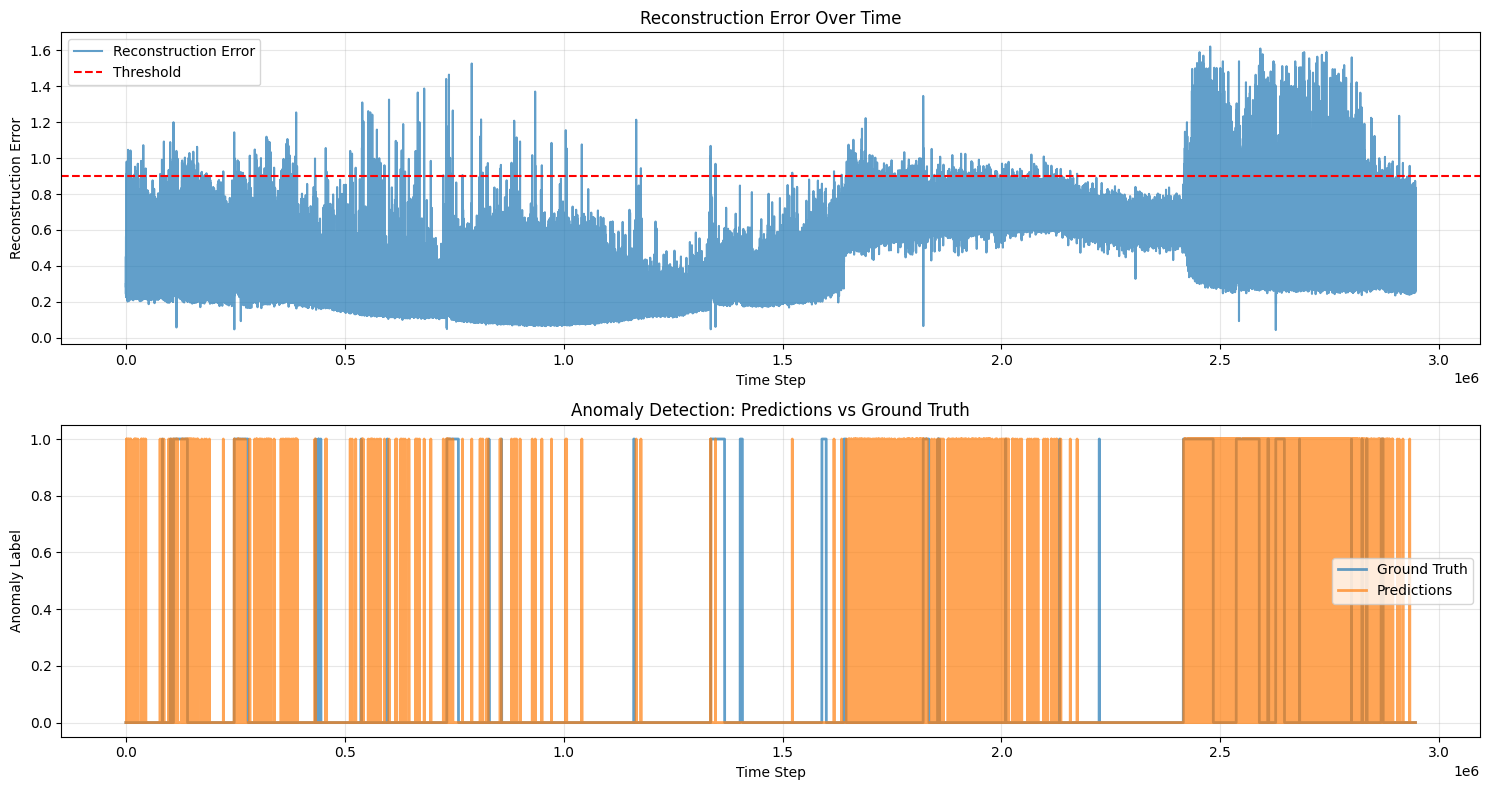

In [34]:
# detector.set_threshold(X_train, percentile=95)
detector.threshold = 0.9 # set_threshold set it to 0.4836

# Evaluate
results = detector.evaluate(X_test, y_test, plot=True)